# Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
import re
from wordcloud import WordCloud, STOPWORDS

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import os
import zipfile
import warnings

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the Dataset

In [2]:
kaggle_input_path = '/kaggle/input/jigsaw-toxic-comment-classification-challenge'

files_in_directory = os.listdir(kaggle_input_path)
print(files_in_directory)


for file_name in files_in_directory:
    # Skip non-zip files if any
    if not file_name.endswith('.zip'):
        continue

    # Path to the zip file
    zip_file_path = os.path.join(kaggle_input_path, file_name)

    # Directory where you want to extract the contents
    output_dir = '/kaggle/working/'

    # Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
        # Print complete paths of the extracted files
        extracted_files = zip_ref.namelist()
        for extracted_file in extracted_files:
            complete_path = os.path.join(output_dir, extracted_file)
            print("Extracted:", complete_path)

['sample_submission.csv', 'test_labels.csv', 'train.csv', 'test.csv']


# Preprocessing

In [3]:
import re

# 停用词列表，可以根据需要进行扩展
stopwords = ["the", "and", "is", "on", "in", "if", "for", "a", "an", "of", "or", "to", "it", "you", "your"]

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove web links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove special characters, punctuation marks, and newlines
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra white spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove stopwords
    text = ' '.join(word for word in text.split() if word.lower() not in stopwords)

    return text.lower()

# Example usage with the provided text
texts = [
    "\nMore\nI can't make any       real sugges%%%%%tions on improvement - I wondered if the section statistics should b|e later on, or a subsect\nion of 'types of accidents'  -I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport"
]

cleaned_texts = [clean_text(text) for text in texts]
print(cleaned_texts)

['more i cant make any real suggestions improvement i wondered section statistics should be later subsect ion types accidents i think references may need tidying so that they are all exact same format ie date format etc i can do that later noone else does first have any preferences formatting style references want do yourself please let me know there appears be backlog articles review so i guess there may be delay until reviewer turns up its listed relevant form eg wikipediagoodarticlenominationstransport']


## Data Visualization to Understand Class Distribution

In [4]:
train = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv")

In [5]:
train['Cleaned_Comments'] = train['comment_text'].apply(clean_text)
train['Cleaned_Comments'].head()

0    explanation why edits made under my username h...
1    daww he matches this background colour im seem...
2    hey man im really not trying edit war its just...
3    more i cant make any real suggestions improvem...
4    sir are my hero any chance remember what page ...
Name: Cleaned_Comments, dtype: object

In [6]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
    wordcloud = WordCloud(width=800, height=400,stopwords=set(STOPWORDS), background_color='black').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

In [7]:
target_labels= [col for col in train.columns if train[col].dtypes == 'int64']
target_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Visualizing the Category of Dataset

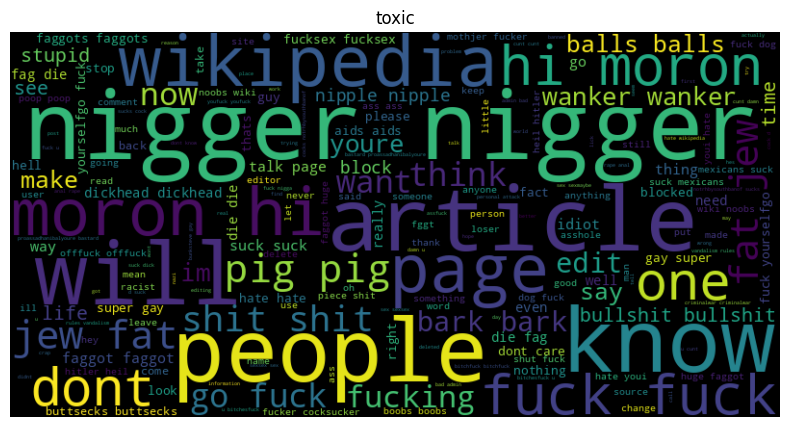

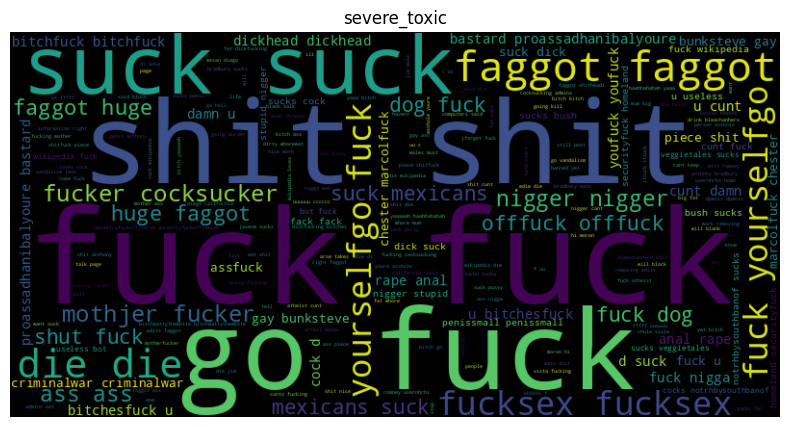

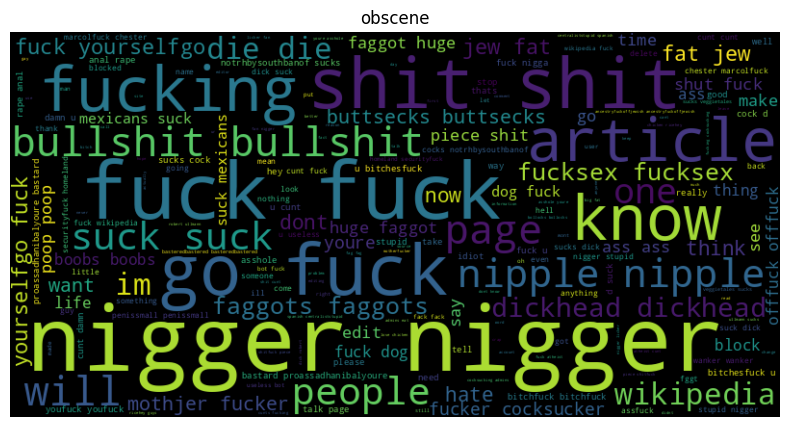

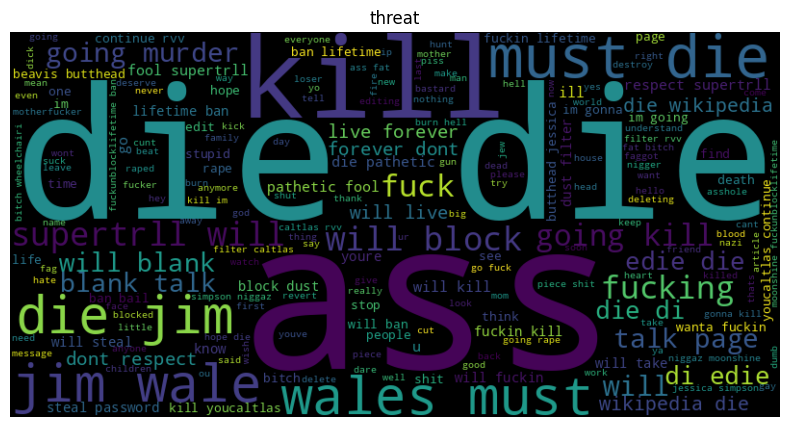

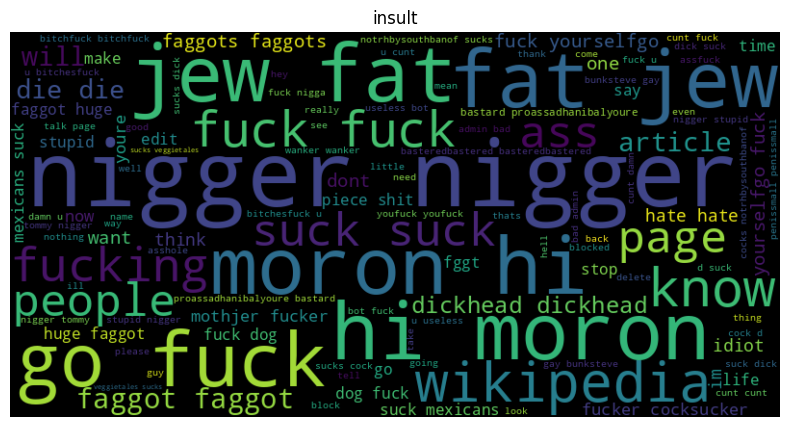

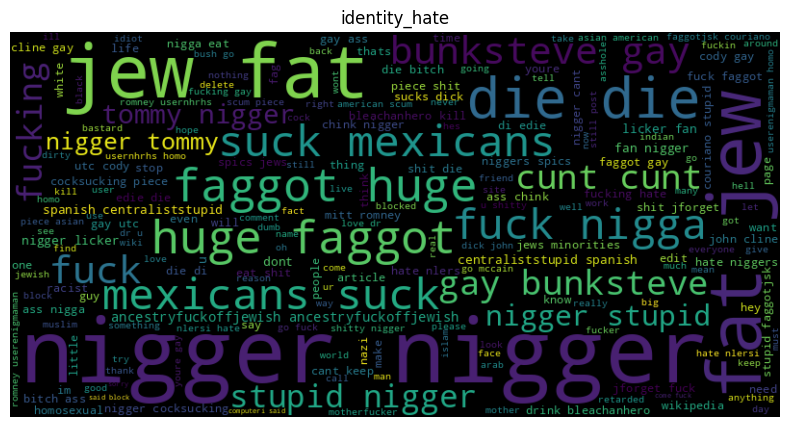

In [8]:
# Plot word clouds for each target label
for label in target_labels:
    text = ' '.join(train[train[label] == 1]['Cleaned_Comments'].values)
    generate_wordcloud(text,Title=label)

In [9]:
comments=train['Cleaned_Comments'].to_list()
comments[:5]

['explanation why edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure some gas after i voted at new york dolls fac please dont remove template from talk page since im retired now',
 'daww he matches this background colour im seemingly stuck with thanks talk january utc',
 'hey man im really not trying edit war its just that this guy constantly removing relevant information talking me through edits instead my talk page he seems care more about formatting than actual info',
 'more i cant make any real suggestions improvement i wondered section statistics should be later subsection types accidents i think references may need tidying so that they are all exact same format ie date format etc i can do that later noone else does first have any preferences formatting style references want do yourself please let me know there appears be backlog articles review so i guess there may be delay until reviewer turns up its listed relevant form eg wiki

In [10]:
train[target_labels].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [11]:
# Calculate the value counts for each target label
value_counts = train[target_labels].sum()

# Add the count for the "neither" category (where all target labels are 0)
value_counts['Good Comments'] = len(train) - value_counts.sum()

fig =px.bar(x= value_counts.index,
            y= value_counts.values,
            color=value_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24_r,
            title='<b>Counts of Target Labels')

fig.update_layout(title='Counts of Target Labels',
                  xaxis_title='Toxicity Labels',
                  yaxis_title='Counts',
                  template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Counts of Target Labels.html', auto_open = True)

'Counts of Target Labels.html'

In [12]:
data = train[target_labels]

In [13]:
train['total'] = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
# first_non_zero_total = train.loc[train['total'] != 0].iloc[0]
temp_train = train[train['total'] != 0]

first_80000_temp_train = train[train['total'] == 0]
first_80000_temp_train = first_80000_temp_train.iloc[:80000]
concatenated_df = pd.concat([first_80000_temp_train, temp_train])
train=concatenated_df
comments=train['Cleaned_Comments'].to_list()
comments[:5]
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Cleaned_Comments,total
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why edits made under my username h...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww he matches this background colour im seem...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man im really not trying edit war its just...,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i cant make any real suggestions improvem...,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir are my hero any chance remember what page ...,0
...,...,...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,our previous conversation fucking shit eating ...,4
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,are mischievious pubic hair,2
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,absurd edits absurd edits great white shark wa...,3
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,hey listen dont ever delete my edits ever agai...,2


<Axes: title={'center': 'Correlation of features & targets'}>

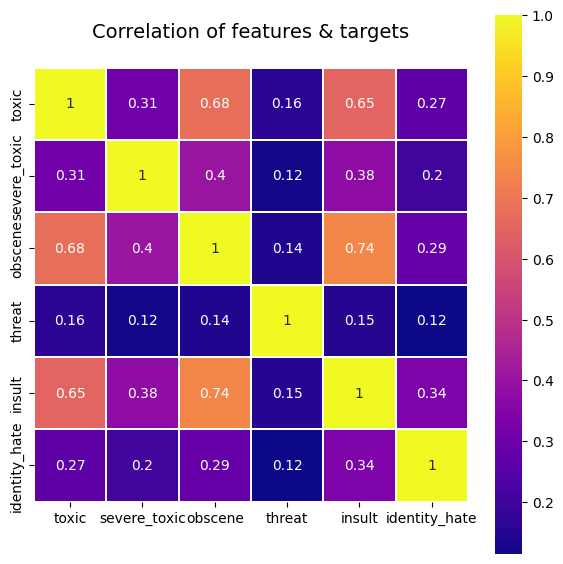

In [14]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

# Split the dataset into Train, Test and Validation

In [15]:
# Split data into training, testing sets & validation sets 
Train_texts, Test_texts, Train_labels, Test_labels = train_test_split(
    comments, train[target_labels].values, test_size=0.2, random_state=2023)

#validation set
test_texts, val_texts, test_labels, val_labels = train_test_split(
    Test_texts, Test_labels, test_size=0.5, random_state=23)

print('numbers of training Dataset ',len(Train_texts))
print('numbers of testing Dataset',len(test_texts))
print('numbers of validation Dataset',len(val_texts))

numbers of training Dataset  76980
numbers of testing Dataset 9622
numbers of validation Dataset 9623


In [16]:
import nltk
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
nltk.download('wordnet')
from nltk.corpus import wordnet

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
import re
from wordcloud import WordCloud, STOPWORDS

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import os
import zipfile
import warnings
import random
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
# Helper function to perform synonym replacement
def synonym_replacement(text, n=5):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stopwords]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    new_text = ' '.join(new_words)
    return new_text

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char.isalpha()])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

# Helper function to perform random insertion
def random_insertion(text, n=3):
    words = text.split()
    new_words = words.copy()
    for _ in range(n):
        word_to_insert = get_random_word()
        random_index = random.randint(0, len(new_words))
        new_words.insert(random_index, word_to_insert)
    new_text = ' '.join(new_words)
    return new_text

def get_random_word():
    # Replace with your method to get random words
    word = random.choice(word_source) if word_source else None
    if word:
        synonyms = get_synonyms(word)
        if synonyms:
            return random.choice(synonyms)
    return word  # Return the original word if no synonyms are found

# Helper function to perform random deletion
def random_deletion(text, p=0.2):
    words = text.split()
    if len(words) == 1:
        return text
    new_words = [word for word in words if random.uniform(0, 1) > p]
    if len(new_words) == 0:
        return random.choice(words)
    new_text = ' '.join(new_words)
    return new_text

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet
augmented_train_texts = []

for text in Train_texts:
    augmented_text = text
    # Apply synonym replacement
    augmented_text = synonym_replacement(augmented_text, n=3)
    # Apply random insertion
    #augmented_text = random_insertion(augmented_text, n=3)
#     # Apply random deletion
    #augmented_text = random_deletion(augmented_text, p=0.2)
    
    augmented_train_texts.append(augmented_text)

type(augmented_train_texts)

list

In [19]:
len(augmented_train_texts)

76980

In [20]:
# 使用np.vstack將它們垂直合併
Train_labels = np.vstack(( Train_labels,  Train_labels))
augmented_train_texts=np.concatenate((augmented_train_texts,Train_texts), axis=0)

In [21]:
len(augmented_train_texts)

153960

# Fine-tune BERT Model for Multilabel Classification

#### Tokenization & encoding using BertTokenizer

In [22]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
    # Initialize empty lists to store tokenized inputs and attention masks
    input_ids = []
    attention_masks = []

    # Iterate through each comment in the 'comments' list
    for comment in comments:
        # Tokenize and encode the comment using the BERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Append the tokenized input and attention mask to their respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists of tokenized inputs and attention masks to PyTorch tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert the labels to a PyTorch tensor with the data type float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Return the tokenized inputs, attention masks, and labels as PyTorch tensors
    return input_ids, attention_masks, labels

In [23]:
# Token Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model =model.to(device)

cuda


In [25]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
    tokenizer, 
#     Train_texts, 
    augmented_train_texts, 
    Train_labels
)

# Step 4: Tokenize and Encode the comments and labels for the test set
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
    tokenizer,
    test_texts,
    test_labels
)

# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    val_texts,
    val_labels
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



## Creating DataLoaders for training dataset

In [26]:
# Creating DataLoader for the balanced dataset
batch_size = 32
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#val
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [27]:
print('Batch Size :',train_loader.batch_size)
Batch =next(iter(train_loader))
print('Each Input ids shape :',Batch[0].shape)
print('Input ids :\n',Batch[0][0])
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0]))
print('Corresponding Attention Mask :\n',Batch[1][0])
print('Corresponding Label:',Batch[2][0])

Batch Size : 32
Each Input ids shape : torch.Size([32, 128])
Input ids :
 tensor([  101,  9051, 20167,  2073, 29278,  2063,  2123,  2102,  4339,  2831,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     

### Initialising optimizer
Initializes the optimizer for training the model 

Adam with Weight Decay (AdamW) is a variant of the Adam optimizer that incorporates weight decay (L2 regularization) during the parameter updates. It is an extension of the original Adam optimizer and addresses some of its limitations when using weight decay as a regularization technique.

In [28]:
# Optimizer setup
#optimizer = AdamW(model.parameters(), lr=0.00002)

optimizer = AdamW([
    {'params': model.bert.encoder.layer[:6].parameters(), 'lr': 0.00002},
    {'params': model.bert.encoder.layer[6:12].parameters(), 'lr': 0.00003},
    {'params': model.bert.encoder.layer[12:18].parameters(), 'lr': 0.00004},
    {'params': model.bert.encoder.layer[18:24].parameters(), 'lr': 0.00005},
], lr=0)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



# Model training 

In [ ]:
import matplotlib.pyplot as plt

# 在train_model函数中定义一个列表来存储损失和验证准确率的历史值
train_loss_history = []
val_loss_history = []
val_accuracy_history = []

def train_model(model, train_loader, val_loader, optimizer, device, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_loader):
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            # 记录训练损失
            train_loss_history.append(loss.item())

            if (step + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Step {step+1}, Training Loss: {loss.item()}')

        model.eval()
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [t.to(device) for t in batch]

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

                # 计算验证准确率
                logits = outputs.logits
                predictions = torch.round(torch.sigmoid(logits))
                correct_predictions += torch.sum(predictions == labels).item()
                total_predictions += labels.size(0)

        val_accuracy = correct_predictions / total_predictions

        # 记录验证损失和准确率
        val_loss_history.append(val_loss / len(val_loader))
        val_accuracy_history.append(val_accuracy)

        print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {val_accuracy}')

    # 绘制损失和验证准确率的折线图
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 调用train_model函数来训练模
train_model(model, train_loader, val_loader, optimizer, device, num_epochs=2)

Epoch 1, Step 10, Training Loss: 0.496273934841156
Epoch 1, Step 20, Training Loss: 0.38773006200790405
Epoch 1, Step 30, Training Loss: 0.3362550437450409
Epoch 1, Step 40, Training Loss: 0.29549694061279297
Epoch 1, Step 50, Training Loss: 0.364189088344574
Epoch 1, Step 60, Training Loss: 0.3211766481399536
Epoch 1, Step 70, Training Loss: 0.3491872549057007
Epoch 1, Step 80, Training Loss: 0.30700239539146423
Epoch 1, Step 90, Training Loss: 0.2805100083351135
Epoch 1, Step 100, Training Loss: 0.2767019271850586
Epoch 1, Step 110, Training Loss: 0.2523074150085449
Epoch 1, Step 120, Training Loss: 0.25907379388809204
Epoch 1, Step 130, Training Loss: 0.25958898663520813
Epoch 1, Step 140, Training Loss: 0.2580219507217407
Epoch 1, Step 150, Training Loss: 0.2834985852241516
Epoch 1, Step 160, Training Loss: 0.24003919959068298
Epoch 1, Step 170, Training Loss: 0.2734588384628296
Epoch 1, Step 180, Training Loss: 0.28251564502716064
Epoch 1, Step 190, Training Loss: 0.27918350696563

In [ ]:
val_accuracy_history=[0,val_accuracy_history[0],val_accuracy_history[1],val_accuracy_history[2]]

# 绘制损失和验证准确率的折线图
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Model Evaluation 

In [ ]:
import numpy as np
import torch
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, hamming_loss
def evaluate_model(model, test_loader, device):
    model.eval()  # 将模型设为评估模式

    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # 获取模型的预测
            outputs = model(input_ids, attention_mask=attention_mask)
            predicted_probs_batch = torch.sigmoid(outputs.logits)  # 多标签分类使用sigmoid
            predicted_probs.append(predicted_probs_batch.cpu().numpy())

            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)

    # 合并预测和标签以进行评估
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
    predicted_labels = (predicted_probs > 0.5).astype(int)  # 二分类应用阈值

    # 计算评估指标
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    tn_rate = recall_score(true_labels, predicted_labels, average='micro', pos_label=0)
    hamming = hamming_loss(true_labels, predicted_labels)
    auc_roc = roc_auc_score(true_labels, predicted_probs, average='micro')

    # 输出评估指标
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'True Negative Rate: {tn_rate:.4f}')
    print(f'Hamming Loss: {hamming:.4f}')

# 调用函数在测试数据上评估模型
evaluate_model(model, test_loader, device)

In [ ]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device):
    model.eval()  # 将模型设为评估模式

    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # 获取模型的预测
            outputs = model(input_ids, attention_mask=attention_mask)
            predicted_probs_batch = torch.sigmoid(outputs.logits)  # 多标签分类使用sigmoid
            predicted_probs.append(predicted_probs_batch.cpu().numpy())

            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)

    # 合并预测和标签以进行评估
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
    predicted_labels = (predicted_probs > 0.5).astype(int)  # 二分类应用阈值

    # 绘制 ROC 曲线和计算 AUC（每个类别分别）
    n_classes = true_labels.shape[1]  # 获取类别数
    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for Class {i}')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for each class')
    plt.legend(loc='lower right')
    plt.show()

# 调用函数在测试数据上评估模型
evaluate_model(model, test_loader, device)

## Save the model

In [ ]:
# Save the tokenizer and model in the same directory
output_dir = "/kaggle/working/Saved_model"
model.save_pretrained(output_dir)  # Save model's state dictionary and configuration
tokenizer.save_pretrained(output_dir)  # Save tokenizer's configuration and vocabulary

In [ ]:
import transformers

print(transformers.__version__)

In [ ]:
pip install transformers==4.3.0


In [ ]:
import os

# Define the output directory
output_dir = "/kaggle/working/Saved_model"

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the model state dictionary
torch.save(model.state_dict(), os.path.join(output_dir, "model_state_dict.pth"))

# Save the tokenizer
tokenizer.save_pretrained(output_dir)


In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer

# 定義輸入目錄
input_dir = "/kaggle/working/Saved_model"

# 初始化模型
loaded_model = BertForSequenceClassification.from_pretrained(input_dir)

# 初始化 tokenizer
loaded_tokenizer = BertTokenizer.from_pretrained(input_dir)


## Load the model

In [ ]:
# Load the tokenizer and model from the saved directory
model_name ="/kaggle/working/Saved_model"
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(model_name).to(device)

# Prediction for user input

In [ ]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer,device=device):
    user_input = [input_text]

    user_encodings = tokenizer(user_input, truncation=True, padding=True, return_tensors="pt")

    user_dataset = TensorDataset(user_encodings['input_ids'], user_encodings['attention_mask'])

    user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

    model.eval()
    with torch.no_grad():
        for batch in user_loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.sigmoid(logits)

    predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
    return predicted_labels[0].tolist()

In [ ]:
text = 'Are you insane!'
predict_user_input(input_text=text)

In [ ]:
predict_user_input(input_text='cum')

In [ ]:
text = "internal ejaculation"
predict_user_input(model=loaded_model, 
                   tokenizer=loaded_tokenizer,
                   input_text=text, 
                   device=device)

In [ ]:
text = "give me a blow job"
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

In [ ]:
text = "blow"
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

In [ ]:
text = "ejaculate in me"
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

In [ ]:
text = "nipple"
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

In [ ]:
text = "I'll kill you"
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

In [ ]:
text = "pussyface % "
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

In [ ]:
text = "how to finger a girl"
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

In [ ]:
AssertionErrortext = "I heard you’re a squirter."
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

In [ ]:
text = "I heard you’re a hero."
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

# Submission

In [ ]:
test['Cleaned_Comments'] = test['comment_text'].apply(clean_text)

In [ ]:
test_labels = pd.read_csv("/kaggle/working/test_labels.csv")
test_labels.head(3)

In [ ]:
model.save("bert_Indcian.h5")

In [ ]:
%%time
test_labels[target_labels]=test['Cleaned_Comments'].apply(predict_user_input).tolist()

# Save the 
test_labels.to_csv('final_submission.csv', index=False, header=True)
df = pd.read_csv('final_submission.csv')
df.head()